![kickstarter-logo](https://ksr-static.imgix.net/tq0sfld-kickstarter-logo-green.png?ixlib=rb-2.1.0&s=0cce952d7b55823ff451a58887a0c578)

# Workshop: Kickstarter data

Kickstarter is a crowdfunding website. Anyone can launch a fund to build something cool and anybody can chip in! It's an amazing resource for indie builders and when it first launched it was a really novel way to raise money around an idea.

We're going to go through the process of exploring and engineering data, building a model, and visualising the results. We'll try to predict whether or not a kickstarter project will be funded.

**Links**
 - Kickstarter website: https://www.kickstarter.com/
 - Shared folder for class: https://drive.google.com/open?id=1PlcVyu8PmquwxkqAAZO0mSidS68xbNZW
 - This code: https://git.generalassemb.ly/DSga38/ds_ga_38

# 1. Load data

First of all we just load up the data and take a peek at what we have.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

# Increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use('fivethirtyeight')

# This makes sure that graphs render in your notebook
%matplotlib inline

In [2]:
# We have two columns that should have datatype 'datetime'
data = pd.read_csv('data/ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

In [3]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


* 'deadline' - date of deadline for the project
* 'goal' - desired amount of money
* 'launched' - launch date for the project
* 'pledged' - amount of local currency pledged
* 'backers' - number of people who have pledged
* 'usd_pledged' - amount of US dollars pledged
* 'usd_pledged_real' - amount of US dollars the project achieved at deadline
* 'usd_goal_real' - amount of US dollars the project asked for initially (amount the project tried to raise)

In [4]:
# Project status
data['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [5]:
# failed - no longer active and didn't reach goal
# successful - no longer active but reached their goal
# canceled - no longer active because someone stopped project
# undefined - campaign hasn't launched yet/incomplete data but is funded ('usd_goal_real' means funded)
# live - currently active, between start and end dates ('usd_goal_real' means funded)
# suspended - approved through launch but on closer inspection do not follow the rules

In [6]:
data[data['state'] == 'undefined']

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378233,997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.0,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",NaN,10.00,7500.00
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.0,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",NaN,2845.61,2752.04
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",NaN,235.00,5000.00
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.0,2015-09-21 22:33:18,2125.00,undefined,0,"N,0""",NaN,3273.36,3080.81


In [7]:
data[data['state'].isin(['undefined', 'live'])]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
40,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.0,live,24,CA,185.65,472.88,2396.36
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.0,undefined,0,"N,0""",NaN,555.00,6500.00
183,1000761521,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,310.0,live,4,US,200.00,310.00,5000.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.0,undefined,0,"N,0""",NaN,3402.08,3211.53
458,1002183790,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,413.0,live,11,GB,13.39,563.32,1159.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.0,undefined,0,"N,0""",NaN,235.00,5000.00
378496,999161903,Case with amplifier,Music,Music,MXN,2018-01-04,300000.0,2017-11-20 02:52:28,0.0,live,0,MX,0.00,0.00,15490.27
378512,999232064,Our little story - Discover Romania,World Music,Music,DKK,2018-01-19,186037.0,2017-12-05 11:11:01,1000.0,live,9,DK,143.57,162.94,30313.01
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.0,2015-09-21 22:33:18,2125.0,undefined,0,"N,0""",NaN,3273.36,3080.81


In [8]:
data.shape[0] - 6361

372300

In [9]:
# Hold out sample - 'live' and 'undefined' projects are already funded so we don't need to explore that data
finished = data['state'].isin(['live', 'undefined'])

In [10]:
# ~ is bitwise operator for NOT, i.e. projects which are 'failed', 'successful', 'canceled' and 'suspended'
# 'canceled' and 'suspended' projects are another version of 'failed'
# 'successful' data helps us understand what ensures funding
data_filtered = data[~ finished]

In [11]:
data_filtered.shape

(372300, 15)

In [12]:
# The data we are interested in is approx 98% of all projects
(data_filtered.shape[0] / data.shape[0]) * 100

98.32013331185414

In [13]:
data_filtered.isnull().sum()

ID                    0
name                  4
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         234
usd_pledged_real      0
usd_goal_real         0
dtype: int64

In [14]:
# Lets visualize distribution of projects in each main category
# AAARRGGH ever since you updated Anaconda this doesn't work because Numpy and Pandas are now incompatible

#fg, ax = plt.subplots(dpi=300)
#data_filtered['main_category'].value_counts().plot(kind='bar', ax=ax);

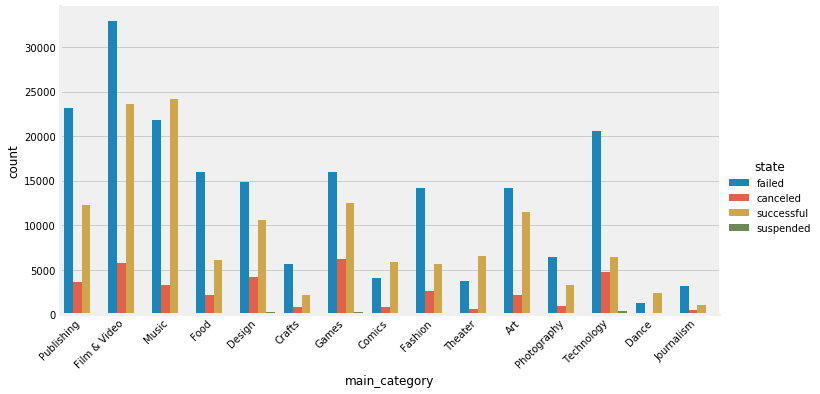

In [15]:
# Distribution of categories, split by status
# Film & Video / Music appear to have most successful projects, but they have most projects in total
# Music is only category which has more successes than failures
sns.catplot('main_category', hue='state', data=data_filtered, kind='count', aspect=2).set_xticklabels(rotation=45, horizontalalignment='right')

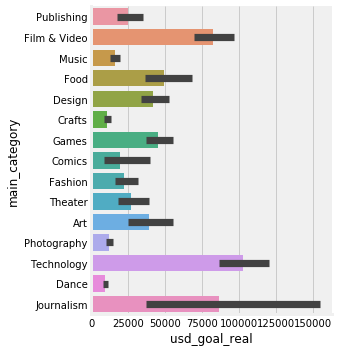

In [16]:
# Total amount of US dollar per category that was raised
# Technology raised the highest funds, followed closely by Film & Video / Journalism (very large confidence interval)
# Music doesn't ask for much in funding
sns.catplot('usd_goal_real', 'main_category', data=data_filtered, kind='bar')

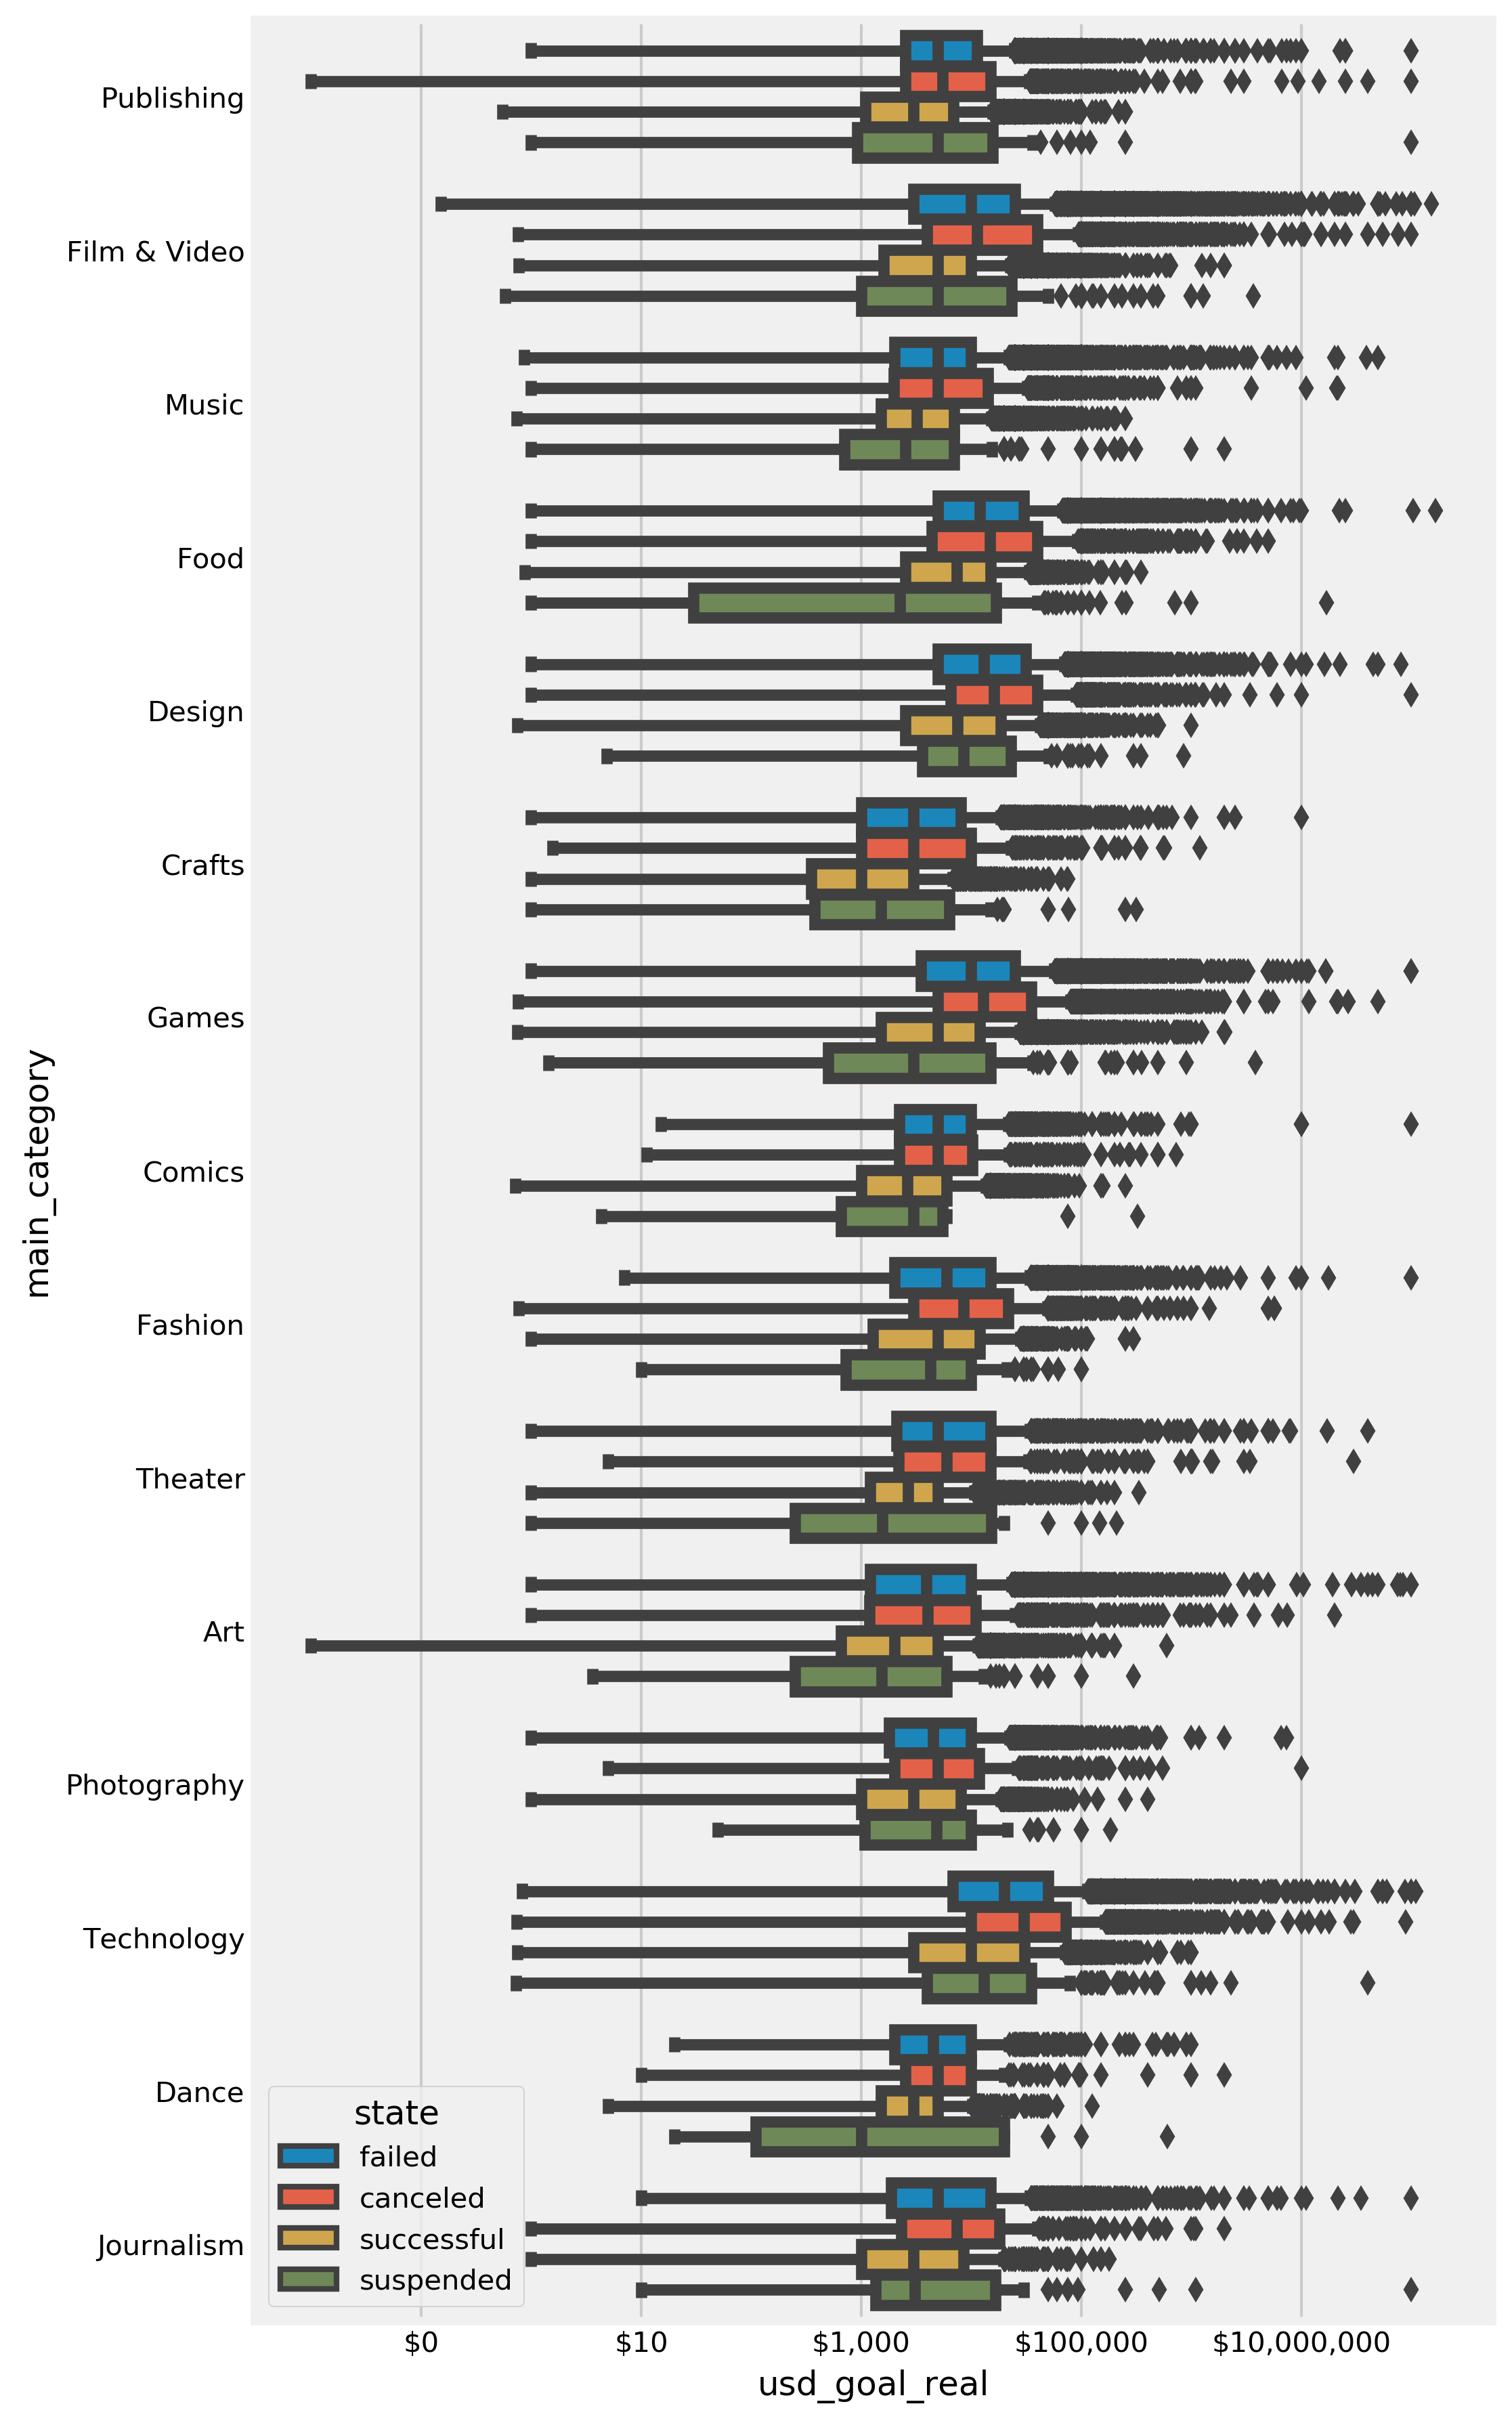

In [17]:
# Compare statistics of main categories, split by status subgroupd, in terms of US dollars raised
fg, ax = plt.subplots(dpi=300, figsize=(7, 15));
ax.set_xscale('log');

sns.boxplot(data=data_filtered, x='usd_goal_real', y='main_category', hue='state');
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

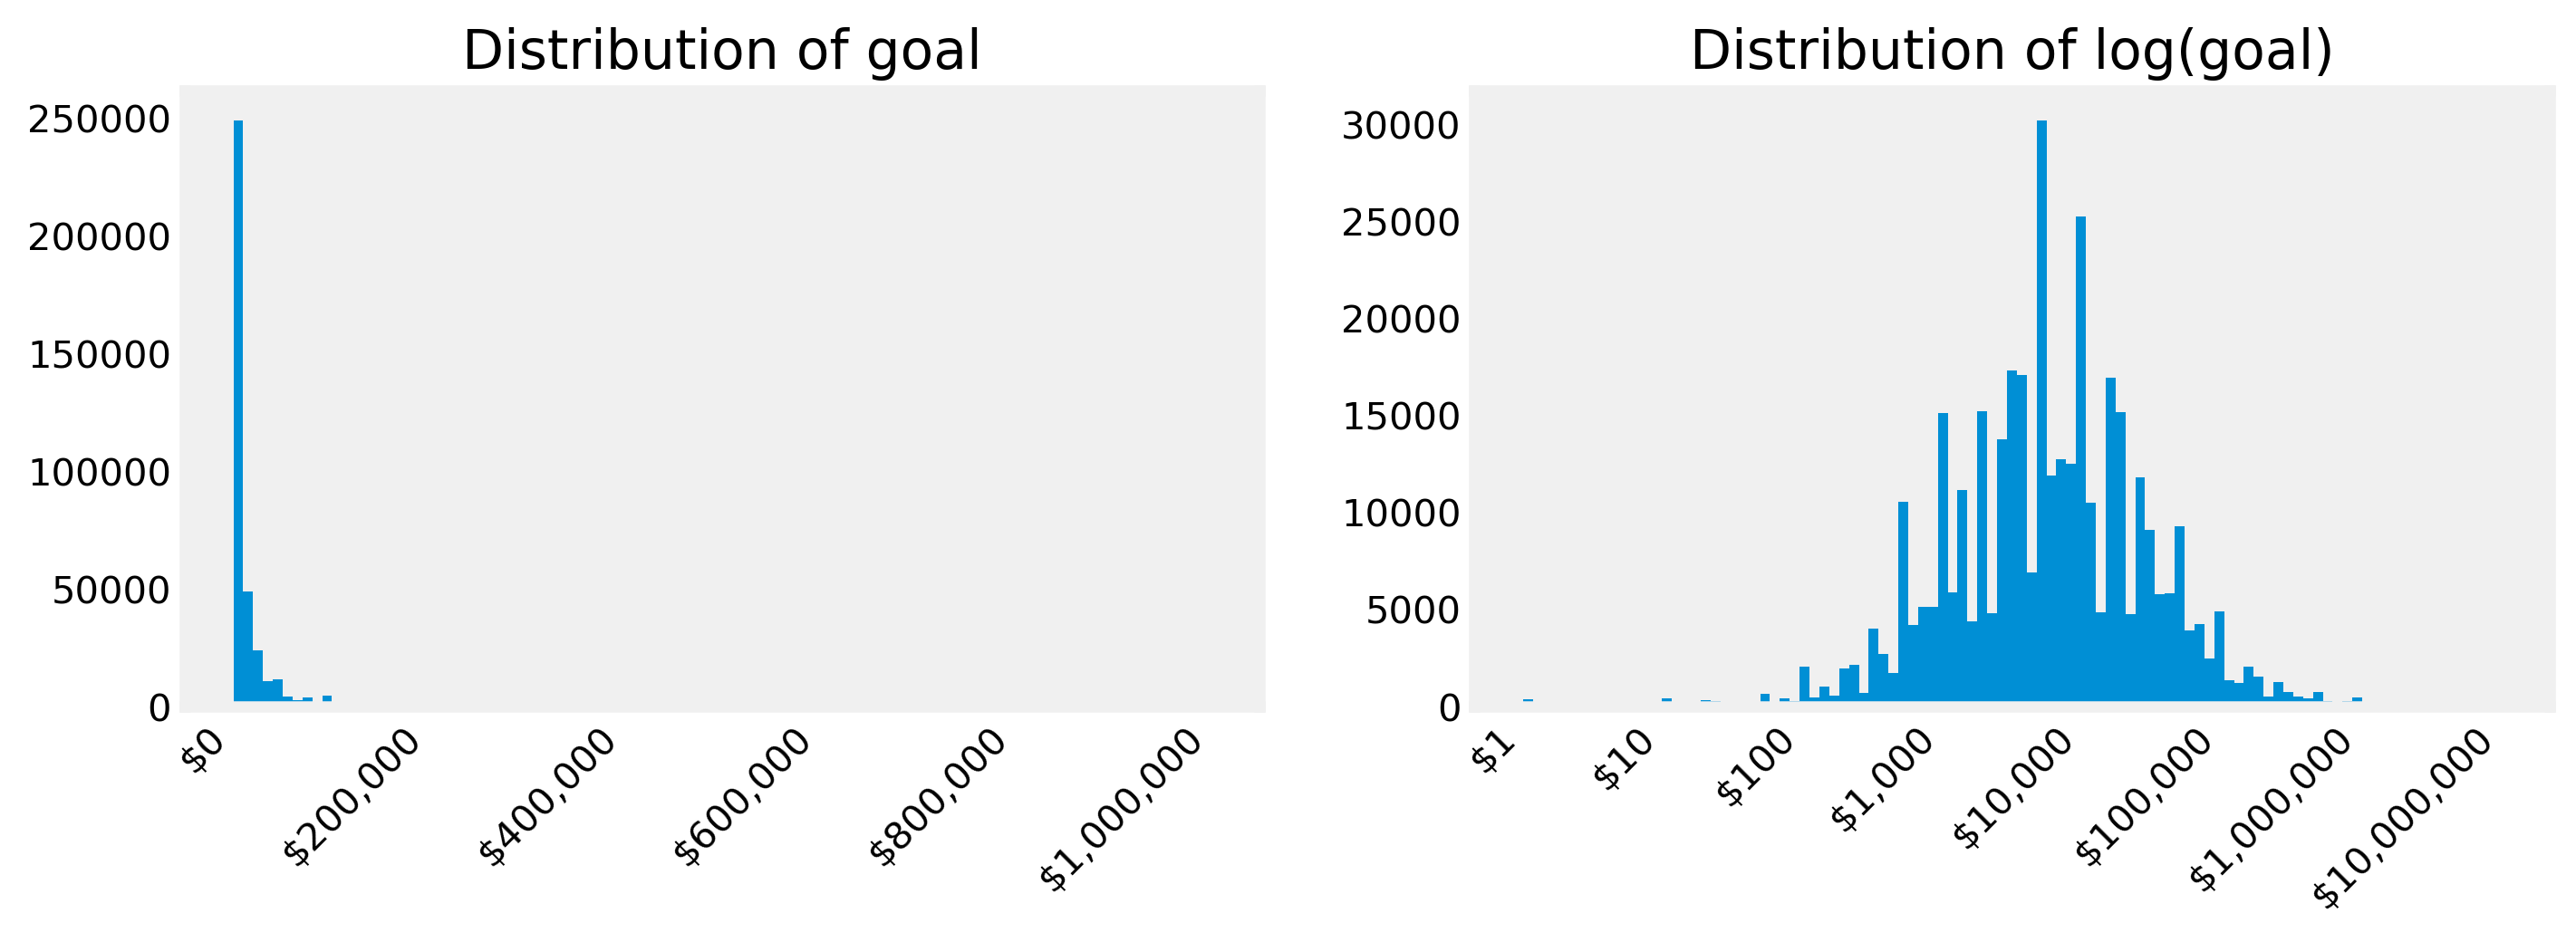

In [18]:
fg, axs = plt.subplots(dpi=300, ncols=2, figsize=(10, 3))

# Spacing the bins evenly assuming normally distributed histogram
bins = np.linspace(0, 10e5, 100)
data_filtered['usd_goal_real'].hist(bins=bins, grid=False, ax=axs[0]);
axs[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));
plt.setp(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[0].set_title('Distribution of goal');

# Spacing the bins evenly on a logged scale assuming normally distributed histogram
bins = np.logspace(0, 7, 100)
axs[1].set_xscale('log');
plt.setp(axs[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axs[1].set_title('Distribution of log(goal)');
data_filtered['usd_goal_real'].hist(bins=bins, grid=False, ax=axs[1]);
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'));

In [19]:
# Based on all the above, the lower the money asked for the more successful the project
# e.g. Music didn't ask for much money, but has many successful projects

In [20]:
data['usd_goal_real'].max()

166361390.71

In [21]:
# Outlier! Billions of dollars raised but the project failed, and it's about potatoes...
data[data['usd_goal_real'] == 166361390.71]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
47803,1243678698,FUCK Potato Salad. Paleo Potato Brownies!,Food,Food,GBP,2014-08-08,99000000.0,2014-07-09 00:24:34,0.0,failed,0,GB,0.0,0.0,1.663614e+08


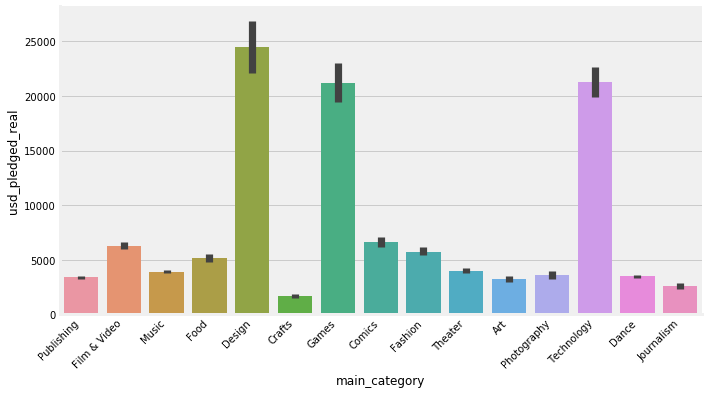

In [22]:
# Total amount of money pledged in the end per category
# In the end, the most money ends up in Design, Games and Technology
# Film & Video and Music don't make much money in the end even though they have most number of projects
sns.catplot('main_category', 'usd_pledged_real', data=data_filtered, kind='bar', aspect=2).set_xticklabels(rotation=45, horizontalalignment='right') 

In [23]:
data['usd_pledged_real'].max()

20338986.27

In [24]:
data[data['usd_pledged_real'] == 20338986.27]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
157270,1799979574,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24 15:44:42,20338986.27,successful,78471,US,20338986.27,20338986.27,500000.0


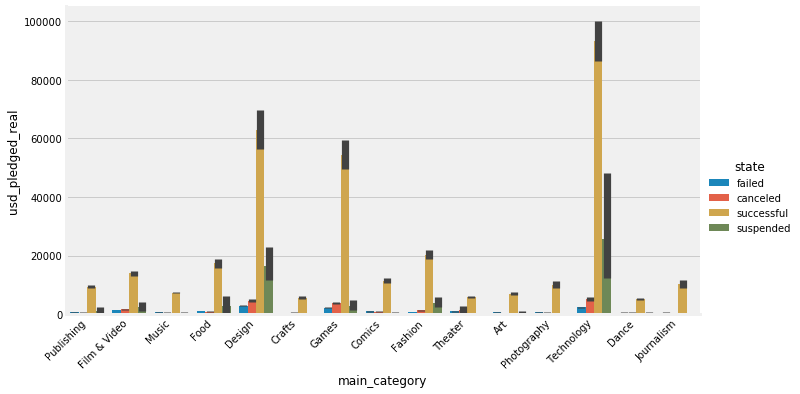

In [25]:
# Distribution of money pledged per category, broken down into states
# Technology, Design and Games gets the most money pledged but they have most projects
sns.catplot('main_category', 'usd_pledged_real', hue='state', data=data_filtered, kind='bar', aspect=2).set_xticklabels(rotation=45, horizontalalignment='right')

In [26]:
# Money is usually pledged when project is live or successful
# It seems that 'usd_goal_real' is more reliable feature than 'usd_pledged' and 'usd_pledged_real'

In [27]:
# Is there any predictive power in the dates? 
data_filtered['launch_dayofweek'] = data_filtered['launched'].dt.dayofweek

C:\Users\shmel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
# On Tuesday, 37.8% of projects launched are successful (higher percentage of successes at start of week)
# Most projects cancelled/failed happens on Saturday
# 53.1% of all projects are failed
pd.crosstab(data_filtered['launch_dayofweek'], data_filtered['state'], margins=True, margins_name='avg percent', normalize='index')

state,canceled,failed,successful,suspended
launch_dayofweek,,,,
0,0.104916,0.527904,0.361875,0.005305
1,0.105861,0.511380,0.378279,0.004481
2,0.102825,0.529717,0.362347,0.005111
3,0.104574,0.532412,0.358335,0.004679
4,0.100977,0.547258,0.346976,0.004789
5,0.106410,0.555991,0.332929,0.004670
6,0.104145,0.529620,0.359285,0.006950
avg percent,0.104161,0.531074,0.359807,0.004958


In [29]:
# Does it make a difference to filter weekends vs non-weekends
data_filtered['launch_weekend'] = data_filtered['launch_dayofweek'] > 4

C:\Users\shmel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# Higher majority of projects launched during the weekend are canceled/failed/suspended
# However, it is approx 50-50 whether it's on the weekend or not
pd.crosstab(data_filtered['launch_weekend'], data_filtered['state'], margins=True, margins_name='Avg percent', normalize='index')

state,canceled,failed,successful,suspended
launch_weekend,,,,
False,0.103936,0.528664,0.362542,0.004859
True,0.105526,0.545694,0.343220,0.005560
Avg percent,0.104161,0.531074,0.359807,0.004958


In [31]:
# What about the length of the project name? Do longer titles put off potential backers?
data_filtered['name_length'] = data_filtered['name'].str.len()

C:\Users\shmel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
# Not significant difference but canceled/suspended projects tend to have longer titles
data_filtered.groupby('state')['name_length'].mean()

state
canceled      40.126666
failed        32.849173
successful    36.244140
suspended     41.656911
Name: name_length, dtype: float64

In [33]:
# Significant difference in number of backers for successful/suspended projects
data_filtered.groupby('state')['backers'].mean()

state
canceled       25.987390
failed         16.422352
successful    263.921362
suspended     105.082340
Name: backers, dtype: float64

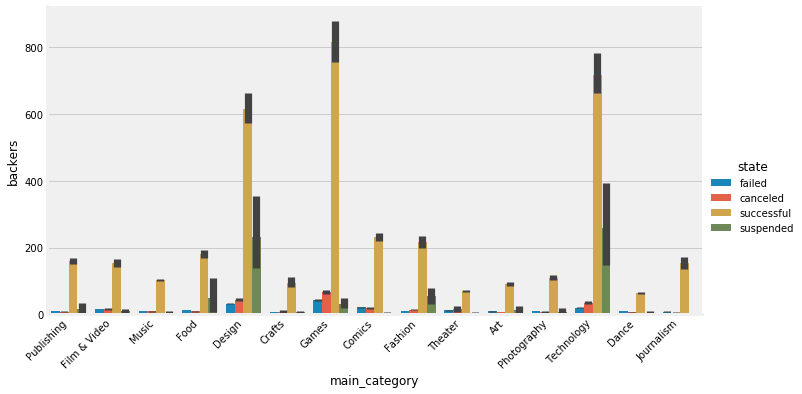

In [34]:
# The more backers, the more successful the project...or is it the other way round?
sns.catplot('main_category', 'backers', hue='state', data=data_filtered, kind='bar', aspect=2).set_xticklabels(rotation=45, horizontalalignment='right')

In [35]:
# Does country have any predictive power
# China and Netherlands have most mean funds raised, US and GB have some of the lowest
data_filtered.groupby('country')['usd_goal_real'].mean()

country
AT       44335.287405
AU       58448.108700
BE       37453.084975
CA       44644.359714
CH      275374.483842
DE       75692.102341
DK       35959.011841
ES       53400.915656
FR       82153.471635
GB       42947.123288
HK       23923.052556
IE       47320.975300
IT       79601.692177
JP       19103.641613
LU       34237.490984
MX       14994.545222
N,0"     20147.470556
NL      109877.368306
NO       67940.524371
NZ       25187.573489
SE       41316.090386
SG       15551.279184
US       43795.671759
Name: usd_goal_real, dtype: float64

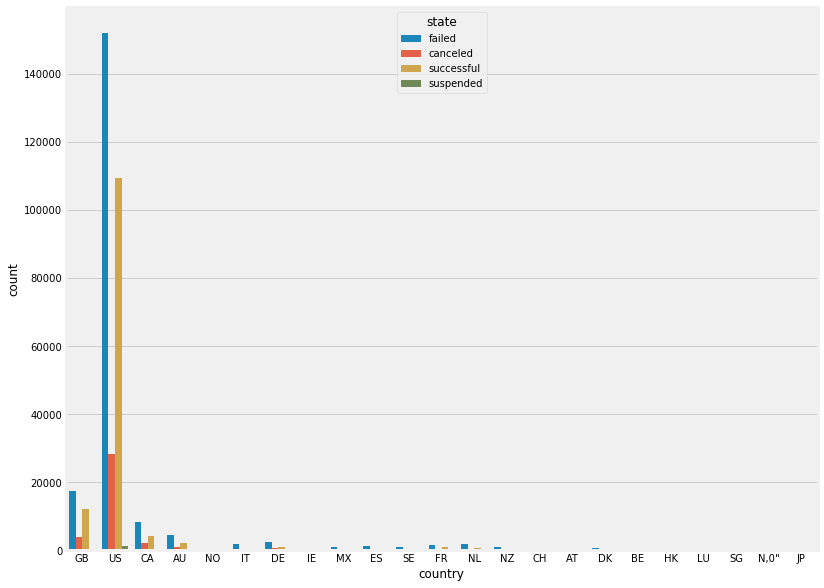

In [36]:
# Distribution of projects by country, split into status subgroups
# Most projects in US and GB
plt.figure(figsize=(12, 10))
sns.countplot(x='country', hue='state', data=data_filtered)

In [37]:
# Map categories to chronological numbers
data['category_num'] = data.main_category.factorize()[0]

In [38]:
data['category_num'].value_counts()

1     63585
2     51918
0     39874
6     35231
12    32569
4     30070
10    28153
3     24602
8     22816
9     10913
7     10819
11    10779
5      8809
14     4755
13     3768
Name: category_num, dtype: int64

In [39]:
# Features are usd_goal_real, backers, main_category (mapped)
feature_cols = ['backers', 'usd_goal_real', 'category_num']
X = data[feature_cols]

In [40]:
# Target column is state mapped to binary values (0 - failed/canceled/suspended and 1 - live/successful/undefined)
data['funded'] = data.state.map({'failed': 0, 'canceled': 0, 'suspended': 0, 'live': 1, 'successful': 1, 'undefined': 1})

In [41]:
# Imbalanced dataset (0 - not funded; 1 - funded)
data['funded'].value_counts()

0    238344
1    140317
Name: funded, dtype: int64

In [42]:
y = data.funded

In [43]:
# Standardize data to remove issues in scaling 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
X_ss = ss.fit_transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [45]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', penalty='l2', C=0.01)

logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [46]:
# Approx 90% accurate after tuning
logreg.score(X_test, y_test)

0.9026049479221685

In [45]:
# Set up Grid Search for tuning model hyperparameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [56]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [57]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.897252 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [47]:
# With tuned model

pred = logreg.predict(X_test)

In [49]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     59412
           1       0.85      0.90      0.87     35254

    accuracy                           0.90     94666
   macro avg       0.89      0.90      0.90     94666
weighted avg       0.90      0.90      0.90     94666



## Train new model using SGD Classifier

Make separate models to evaluate each learning rate, because it takes to long to do complete evaluation via Grid Search across all learning rates.

### SGD Classifier set with 'optimal' learning rate

In [54]:
sgd_optimal = SGDClassifier(loss='log', penalty='l1', alpha=1.0, learning_rate='optimal', random_state=42)

In [55]:
sgd_optimal.fit(X_train, y_train)

SGDClassifier(alpha=1.0, loss='log', penalty='l1', random_state=42)

In [56]:
sgd_optimal.score(X_test, y_test)

0.8817949422179029

In [51]:
# Set up Grid Search for tuning SGD hyperparameters

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalties = ['l1', 'l2', 'elasticnet']

In [52]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

grid = dict(penalty=penalties, alpha=alphas)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=sgd_optimal, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [53]:
print("Best score for optimal learning rate: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best score for optimal learning rate: 0.876540 using {'alpha': 1, 'penalty': 'l1'}


In [ ]:
# Same as Logistic Regression

### SGD Classifier set with 'constant' learning rate

In [65]:
sgd_constant = SGDClassifier(loss='log', penalty='l1', alpha=0.1, learning_rate='constant', eta0=0.01, random_state=42)

In [66]:
sgd_constant.fit(X_train, y_train)

SGDClassifier(alpha=0.1, eta0=0.01, learning_rate='constant', loss='log',
              penalty='l1', random_state=42)

In [67]:
sgd_constant.score(X_test, y_test)

0.8934464327213572

In [62]:
# Set up Grid Search for tuning SGD hyperparameters

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalties = ['l1', 'l2', 'elasticnet']
eta_values = [0.0001, 0.001, 0.01, 0.1, 1]

In [63]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

grid = dict(penalty=penalties, alpha=alphas, eta0=eta_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=sgd_constant, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [64]:
print("Best score for constant learning rate: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best score for constant learning rate: 0.844676 using {'alpha': 0.1, 'eta0': 0.01, 'penalty': 'l1'}


In [ ]:
# Same as Logistic Regression

### SGD Classifier set with 'invscaling' learning rate

In [75]:
sgd_invscaling = SGDClassifier(loss='log', penalty='l1', alpha=0.1, learning_rate='invscaling', eta0=0.01, random_state=42)

In [76]:
sgd_invscaling.fit(X_train, y_train)

SGDClassifier(alpha=0.1, eta0=0.01, learning_rate='invscaling', loss='log',
              penalty='l1', random_state=42)

In [77]:
sgd_invscaling.score(X_test, y_test)

0.6741174233621363

In [71]:
# Set up Grid Search for tuning SGD hyperparameters

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalties = ['l1', 'l2', 'elasticnet']
eta_values = [0.0001, 0.001, 0.01, 0.1, 1]

In [72]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

grid = dict(penalty=penalties, alpha=alphas, eta0=eta_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=sgd_invscaling, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [74]:
print("Best score for invscaling learning rate: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best score for invscaling learning rate: 0.882267 using {'alpha': 0.1, 'eta0': 0.01, 'penalty': 'l1'}


In [ ]:
# Worst model so far

### SGD Classifier set with 'adaptive' learning rate

In [59]:
sgd_adaptive = SGDClassifier(loss='log', penalty='l2', alpha=0.001, learning_rate='adaptive', eta0=0.0001, random_state=42)

In [60]:
sgd_adaptive.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=0.0001, learning_rate='adaptive', loss='log',
              random_state=42)

In [61]:
sgd_adaptive.score(X_test, y_test)

0.8836963640589018

In [56]:
# Set up Grid Search for tuning SGD hyperparameters

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalties = ['l1', 'l2']
eta_values = [0.0001, 0.001, 0.01, 0.1, 1]

In [57]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

grid = dict(penalty=penalties, alpha=alphas, eta0=eta_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_adaptive = GridSearchCV(estimator=sgd_adaptive, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
result_adaptive = grid_adaptive.fit(X_train, y_train)

In [58]:
print("Best score for adaptive learning rate: %f using %s" % (result_adaptive.best_score_, result_adaptive.best_params_))

Best score for adaptive learning rate: 0.886125 using {'alpha': 0.001, 'eta0': 0.0001, 'penalty': 'l2'}


In [62]:
y_pred = sgd_adaptive.predict(X_test)

In [63]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     59412
           1       0.80      0.92      0.86     35254

    accuracy                           0.88     94666
   macro avg       0.87      0.89      0.88     94666
weighted avg       0.89      0.88      0.89     94666



In [ ]:
# Logistic Regression seems to be best model based on evaluation results